Files already downloaded and verified
Files already downloaded and verified


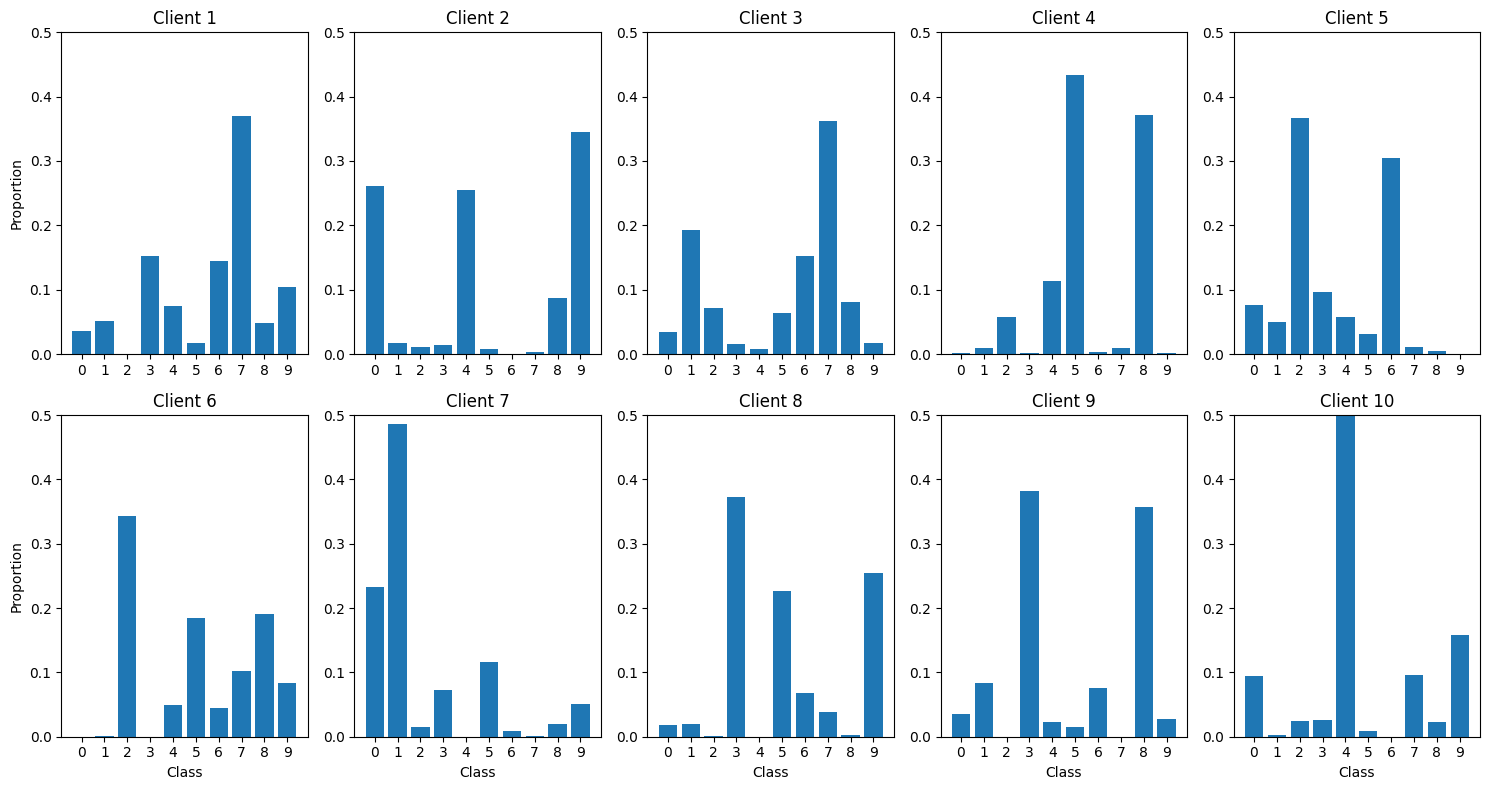

Files already downloaded and verified
Files already downloaded and verified

Round 1/50
Train Loss: 1.3335, Train Accuracy: 0.5396
Test Accuracy: 0.1000

Round 2/50
Train Loss: 1.2123, Train Accuracy: 0.5814
Test Accuracy: 0.2180

Round 3/50
Train Loss: 1.1355, Train Accuracy: 0.6063
Test Accuracy: 0.3410

Round 4/50
Train Loss: 1.0826, Train Accuracy: 0.6252
Test Accuracy: 0.3764

Round 5/50
Train Loss: 1.0297, Train Accuracy: 0.6408
Test Accuracy: 0.4253

Round 6/50
Train Loss: 0.9919, Train Accuracy: 0.6574
Test Accuracy: 0.4522

Round 7/50
Train Loss: 0.9412, Train Accuracy: 0.6742
Test Accuracy: 0.4989

Round 8/50
Train Loss: 0.9084, Train Accuracy: 0.6863
Test Accuracy: 0.5128

Round 9/50
Train Loss: 0.8719, Train Accuracy: 0.6967
Test Accuracy: 0.5485

Round 10/50
Train Loss: 0.8392, Train Accuracy: 0.7116
Test Accuracy: 0.5676

Round 11/50
Train Loss: 0.8179, Train Accuracy: 0.7186
Test Accuracy: 0.6014

Round 12/50
Train Loss: 0.7957, Train Accuracy: 0.7266
Test Accuracy: 0.59

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
import copy
from collections import OrderedDict

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Hyperparameters
NUM_CLIENTS = 10
BATCH_SIZE = 64
LOCAL_EPOCHS = 2
GLOBAL_EPOCHS = 20
LEARNING_RATE = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
COMM_ROUNDS = 50  # Communication rounds
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.2)
        
        # Second convolutional block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.3)
        
        # Third convolutional block
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.dropout3 = nn.Dropout(0.4)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        # First block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Second block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Third block
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Fully connected
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        x = self.fc2(x)
        
        return x

# Load and preprocess CIFAR-10 dataset
def load_and_preprocess_data():
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train)
    
    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test)
    
    return trainset, testset

# Split data for federated setting (non-IID)
def create_client_data(trainset, num_clients=10, alpha=0.5):
    """
    Split data into non-IID partitions using Dirichlet distribution
    alpha: concentration parameter (lower alpha = more non-IID)
    """
    # Initialize client datasets
    client_loaders = []
    client_sizes = []
    
    # Get all labels from the dataset
    targets = torch.tensor(trainset.targets)
    num_classes = 10
    
    # Group indices by class
    class_indices = [torch.where(targets == i)[0] for i in range(num_classes)]
    
    # Sample from Dirichlet distribution
    client_distribution = np.random.dirichlet(alpha * np.ones(num_clients), num_classes)
    
    # Allocate data to clients based on the distribution
    client_indices = [[] for _ in range(num_clients)]
    
    for c in range(num_classes):
        for i in range(num_clients):
            # Calculate number of samples from this class to allocate to this client
            num_samples = int(len(class_indices[c]) * client_distribution[c][i])
            
            # Randomly select indices without replacement
            if num_samples > 0:
                selected = np.random.choice(class_indices[c].numpy(), 
                                          min(num_samples, len(class_indices[c])), 
                                          replace=False)
                client_indices[i].extend(selected)
                # Remove selected indices
                class_indices[c] = class_indices[c][~np.isin(class_indices[c], selected)]
    
    # Create dataloaders for each client
    for i in range(num_clients):
        # Create subset dataset
        client_dataset = torch.utils.data.Subset(trainset, client_indices[i])
        client_loader = DataLoader(client_dataset, batch_size=BATCH_SIZE, shuffle=True)
        
        client_loaders.append(client_loader)
        client_sizes.append(len(client_indices[i]))
    
    return client_loaders, client_sizes

# Client update function
def client_update(client_model, optimizer, dataloader, epochs=LOCAL_EPOCHS):
    # Set model to training mode
    client_model.train()
    
    # Track metrics
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        epoch_correct = 0
        epoch_total = 0
        
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = client_model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Update statistics
            epoch_loss += loss.item()
            _, predicted = outputs.max(1)
            epoch_total += targets.size(0)
            epoch_correct += predicted.eq(targets).sum().item()
        
        # Aggregate epoch statistics
        train_loss += epoch_loss / len(dataloader)
        train_correct += epoch_correct
        train_total += epoch_total
    
    # Average metrics over epochs
    train_loss /= epochs
    train_accuracy = train_correct / train_total
    
    return train_loss, train_accuracy

# Weight aggregation function (FedAvg)
def aggregate_weights(client_weights, client_sizes):
    """
    Aggregate weights using weighted average based on client dataset sizes
    """
    total_size = sum(client_sizes)
    aggregated_weights = OrderedDict()
    
    # Get keys from the first client's model
    keys = client_weights[0].keys()
    
    # Weighted sum of weights
    for key in keys:
        # Initialize with zeros of the right shape and type
        aggregated_weights[key] = torch.zeros_like(client_weights[0][key], dtype=torch.float32)
        
        for i, client_w in enumerate(client_weights):
            weight = client_sizes[i] / total_size
            # Handle integer tensors by converting to float for the weighted average calculation
            if client_w[key].dtype == torch.int64 or client_w[key].dtype == torch.int32:
                aggregated_weights[key] += client_w[key].float() * weight
                # Convert back to the original dtype after all additions
                if i == len(client_weights) - 1:
                    aggregated_weights[key] = aggregated_weights[key].to(client_w[key].dtype)
            else:
                aggregated_weights[key] += client_w[key] * weight
    
    return aggregated_weights

# Learning rate scheduler
def get_lr_scheduler(optimizer):
    """
    Create a learning rate scheduler that reduces LR based on progress
    """
    return torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=[15, 30, 45], gamma=0.1
    )

# Evaluate model on test dataset
def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    test_accuracy = correct / total
    return test_accuracy

# Main federated learning process
def run_federated_learning():
    # Load and preprocess data
    trainset, testset = load_and_preprocess_data()
    testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Create client data (non-IID)
    client_loaders, client_sizes = create_client_data(trainset, NUM_CLIENTS, alpha=0.5)
    
    # Initialize global model
    global_model = CNN().to(DEVICE)
    
    # Track metrics
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    # Federated learning rounds
    for round_num in range(COMM_ROUNDS):
        print(f"\nRound {round_num+1}/{COMM_ROUNDS}")
        
        # Get the global model state dict
        global_weights = global_model.state_dict()
        
        # Client update
        client_weights = []
        round_train_loss = 0
        round_train_accuracy = 0
        
        # Select clients (can implement partial selection if needed)
        selected_clients = list(range(NUM_CLIENTS))
        
        for client_idx in selected_clients:
            # Create and initialize client model with global weights
            client_model = CNN().to(DEVICE)
            client_model.load_state_dict(global_weights)
            
            # Initialize optimizer
            optimizer = optim.SGD(client_model.parameters(), 
                                  lr=LEARNING_RATE, 
                                  momentum=MOMENTUM, 
                                  weight_decay=WEIGHT_DECAY)
            
            # Get client data
            dataloader = client_loaders[client_idx]
            
            # Update client model
            client_loss, client_accuracy = client_update(
                client_model,
                optimizer,
                dataloader
            )
            
            # Collect client metrics and weights
            weight = client_sizes[client_idx] / sum([client_sizes[i] for i in selected_clients])
            round_train_loss += client_loss * weight
            round_train_accuracy += client_accuracy * weight
            client_weights.append(copy.deepcopy(client_model.state_dict()))
        
        # Aggregate weights
        aggregated_weights = aggregate_weights(
            client_weights,
            [client_sizes[i] for i in selected_clients]
        )
        
        # Update global model
        global_model.load_state_dict(aggregated_weights)
        
        # Evaluate on test set
        test_accuracy = evaluate_model(global_model, testloader)
        
        # Record metrics
        train_losses.append(round_train_loss)
        train_accuracies.append(round_train_accuracy)
        test_accuracies.append(test_accuracy)
        
        print(f"Train Loss: {round_train_loss:.4f}, Train Accuracy: {round_train_accuracy:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Save the global model
    torch.save(global_model.state_dict(), "federated_cnn_cifar10.pth")
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Communication Round')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train')
    plt.plot(test_accuracies, label='Test')
    plt.title('Accuracy')
    plt.xlabel('Communication Round')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('federated_learning_results.png')
    plt.show()
    
    return global_model, train_losses, train_accuracies, test_accuracies

# Client data visualization
def visualize_client_data_distribution(client_loaders):
    # Get labels from each client
    client_labels = []
    
    for loader in client_loaders:
        labels = []
        for _, targets in loader:
            labels.extend(targets.tolist())
        client_labels.append(labels)
    
    # Count class distribution for each client
    class_counts = []
    for labels in client_labels:
        counts = np.zeros(10)
        for label in labels:
            counts[label] += 1
        class_counts.append(counts)
    
    # Plot distribution
    plt.figure(figsize=(15, 8))
    
    for i, counts in enumerate(class_counts):
        plt.subplot(2, 5, i+1)
        plt.bar(range(10), counts / sum(counts))
        plt.title(f'Client {i+1}')
        plt.ylim(0, 0.5)
        plt.xticks(range(10))
        if i >= 5:
            plt.xlabel('Class')
        if i % 5 == 0:
            plt.ylabel('Proportion')
    
    plt.tight_layout()
    plt.savefig('client_data_distribution.png')
    plt.show()

if __name__ == "__main__":
    # Load data
    trainset, testset = load_and_preprocess_data()
    
    # Create client data
    client_loaders, client_sizes = create_client_data(trainset, NUM_CLIENTS)
    
    # Visualize client data distribution
    visualize_client_data_distribution(client_loaders)
    
    # Run federated learning
    global_model, train_losses, train_accuracies, test_accuracies = run_federated_learning()
    
    # Final evaluation
    testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)
    final_accuracy = evaluate_model(global_model, testloader)
    print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")